<a href="https://colab.research.google.com/github/haysroy/RET-2024/blob/main/redshifts_and_redshifts_per_bin_working_6_27_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The code below comes from LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari
!pip install -q condacolab
import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyccl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.40|       hf600244_0         5.2 MB  conda-forge
    binutils_linux-64-2.40     |       hb3c18ed_9          29 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    ca-certificates-2024.6.2   |       hbcca054_0         152 KB  conda-forge
    camb-1.5.5                 |  py310h877fa1b_0         881 KB  co

#Define and visualize a sample redshift distribution of galaxies for cosmological analysis

The purpose of this code is to compute and visualize the redshift distribution of galaxies for a given set of cosmological parameters and observational constraints. This distribution is used to understand galaxy clustering and large-scale structure in the universe, which are key aspects of cosmological research and analysis.

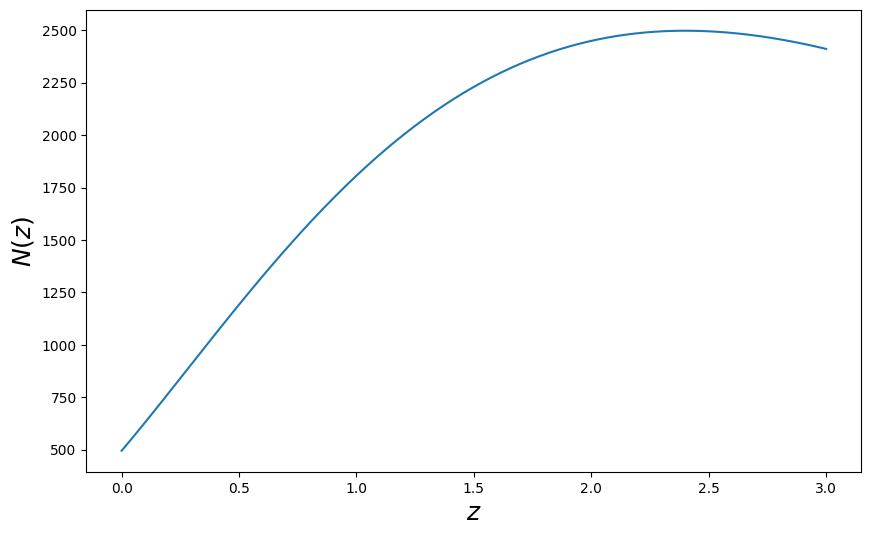

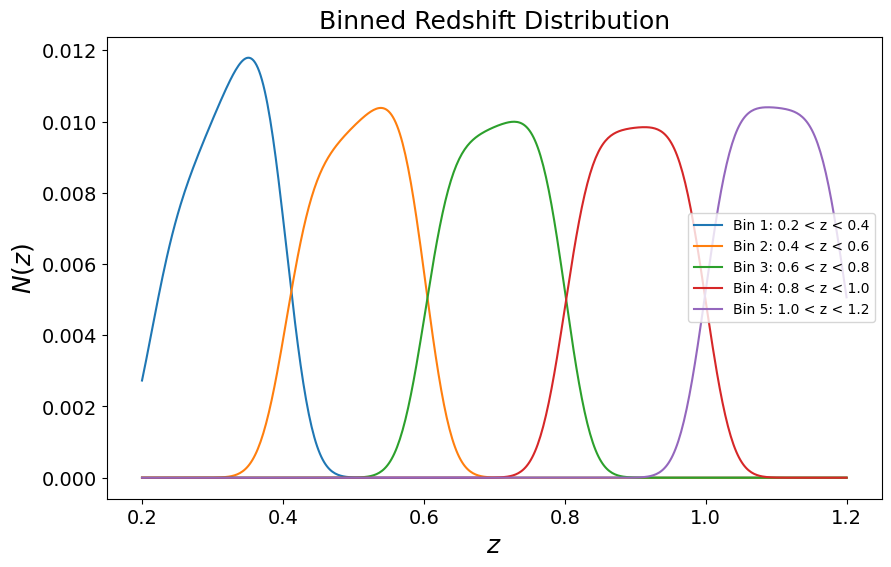

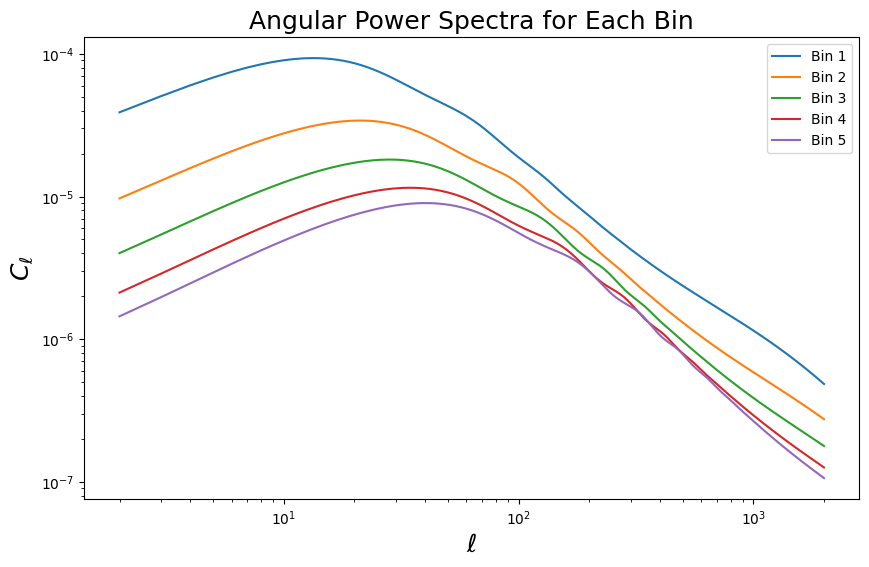

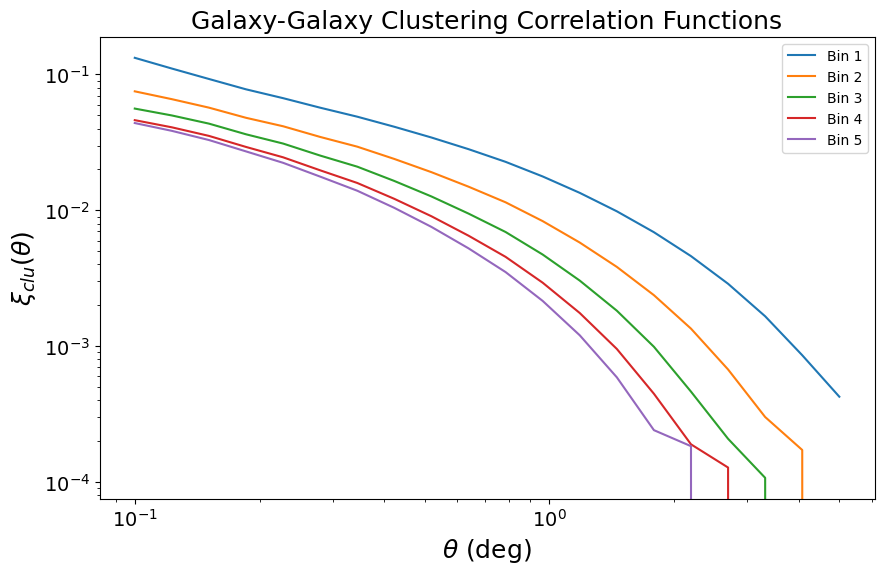

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.integrate import quad

class SRDRedshiftDistributions(object):
    def __init__(self,
                 redshift_range,
                 galaxy_sample={},
                 forecast_year={}):

        self.redshift_range = redshift_range
    def smail_type_distribution(self,
                                redshift_range,
                                pivot_redshift=None,
                                alpha=None,
                                beta=None):
        if not pivot_redshift:
            pivot_redshift = self.srd_parameters["z_0"]
        if not alpha:
            alpha = self.srd_parameters["alpha"]
        if not beta:
            beta = self.srd_parameters["beta"]

        redshift_distribution = [z ** beta * exp(-(z / pivot_redshift) ** alpha) for z in redshift_range]

        return redshift_distribution

        redshift_distribution = self.smail_type_distribution(redshift_range)

        # Normalise the redshift distribution
        if normalised:
            normalisation = np.array(simpson(redshift_distribution, redshift_range))
            redshift_distribution = np.array(redshift_distribution / normalisation)

        combined_data = {"redshift": redshift_range, "dndz": redshift_distribution}
        # Save the redshift distribution to a .csv file

        if save_file:
            self.save_to_file(combined_data, file_format)

        return redshift_distribution

    def save_to_file(self, data, file_format="npy"):

        if file_format == "npy":
            np.save(f"./srd_{self.galaxy_sample}_dndz_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            dndz_df = pandas.DataFrame(data)
            dndz_df.to_csv(f"./srd_{self.galaxy_sample}_dndz_year_{self.forecast_year}.csv", index=False)

# Define the cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

z = np.linspace(0., 3., 512)
i_lim = 26.0  # Limiting i-band magnitude
z0 = 0.0417 * i_lim - 0.744
Ngal = 46.0 * 100.31 * (i_lim - 25.0)  # Normalization, galaxies/arcmin^2

# Redshift distribution
beta = 2.0
alpha = 0.25
pivot_redshift = 0.5
redshift_range = np.linspace(0.2, 1.2, 512)
#redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in redshift_range]
#redshift_distribution = [1./(2. * pivot_redshift) * (z / pivot_redshift)**2. * np.exp(-z / pivot_redshift) for z in redshift_range]
dNdz = Ngal * np.array(redshift_distribution)

# Plot the redshift distribution
plt.figure(figsize=(10, 6))
plt.plot(z, dNdz, label='Redshift Distribution')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)

class RedshiftBinning:
    def __init__(self, z, dNdz, bin_edges, sigma):
        self.z = z
        self.dNdz = dNdz
        self.bin_edges = bin_edges
        self.sigma = sigma
        self.binned_distribution = np.zeros((len(bin_edges) - 1, len(z)))

    def gaussian_contribution(self, z_i, sigma, bin_edge1, bin_edge2):
        """Calculate the contribution of z_i to the bin between bin_edge1 and bin_edge2."""
        norm_factor = 1 / (sigma * np.sqrt(2 * np.pi))
        integrand = lambda x: norm_factor * np.exp(-0.5 * ((x - z_i) / sigma)**2)
        contribution, _ = quad(integrand, bin_edge1, bin_edge2)
        return contribution

    def bin_data(self):
        """Bin the data points according to their Gaussian distributions."""
        for i in range(len(self.z)):
            for j in range(len(self.bin_edges) - 1):
                bin_edge1 = self.bin_edges[j]
                bin_edge2 = self.bin_edges[j + 1]
                self.binned_distribution[j, i] = self.dNdz[i] * self.gaussian_contribution(self.z[i], self.sigma[i], bin_edge1, bin_edge2)

        # Normalize the binned distribution
        for j in range(len(self.bin_edges) - 1):
            self.binned_distribution[j, :] /= np.sum(self.binned_distribution[j, :])

    def plot_binned_distribution(self):
        """Plot the binned redshift distribution."""
        bin_centers = 0.5 * (self.bin_edges[:-1] + self.bin_edges[1:])
        plt.figure(figsize=(10, 6))
        for j in range(len(self.bin_edges) - 1):
            plt.plot(self.z, self.binned_distribution[j, :], label=f'Bin {j+1}: {self.bin_edges[j]:.1f} < z < {self.bin_edges[j+1]:.1f}')
        plt.xlabel('$z$', fontsize=18)
        plt.ylabel('$N(z)$', fontsize=18)
        plt.title('Binned Redshift Distribution', fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend()
        plt.show()

# Define the bin edges and sigma (uncertainty)
bin_edges = np.linspace(0.2, 1.2, 6)
sigma = 0.03 * np.ones_like(redshift_range)  # Photometric redshift uncertainty measure of 0.03

# Instantiate the binning class and bin the data
binning = RedshiftBinning(redshift_range, redshift_distribution, bin_edges, sigma)
binning.bin_data()
binning.plot_binned_distribution()

# Create NumberCountsTracers for each bin using the binned redshift distribution
tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz_bin = binning.binned_distribution[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot the angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Angular Power Spectra for Each Bin', fontsize=18)
plt.show()

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Plot the correlations for galaxy-galaxy clustering
plt.figure(figsize=(10, 6))
for i, xi_clu in enumerate(correlations):
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1}')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)', fontsize=18)
plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.show()


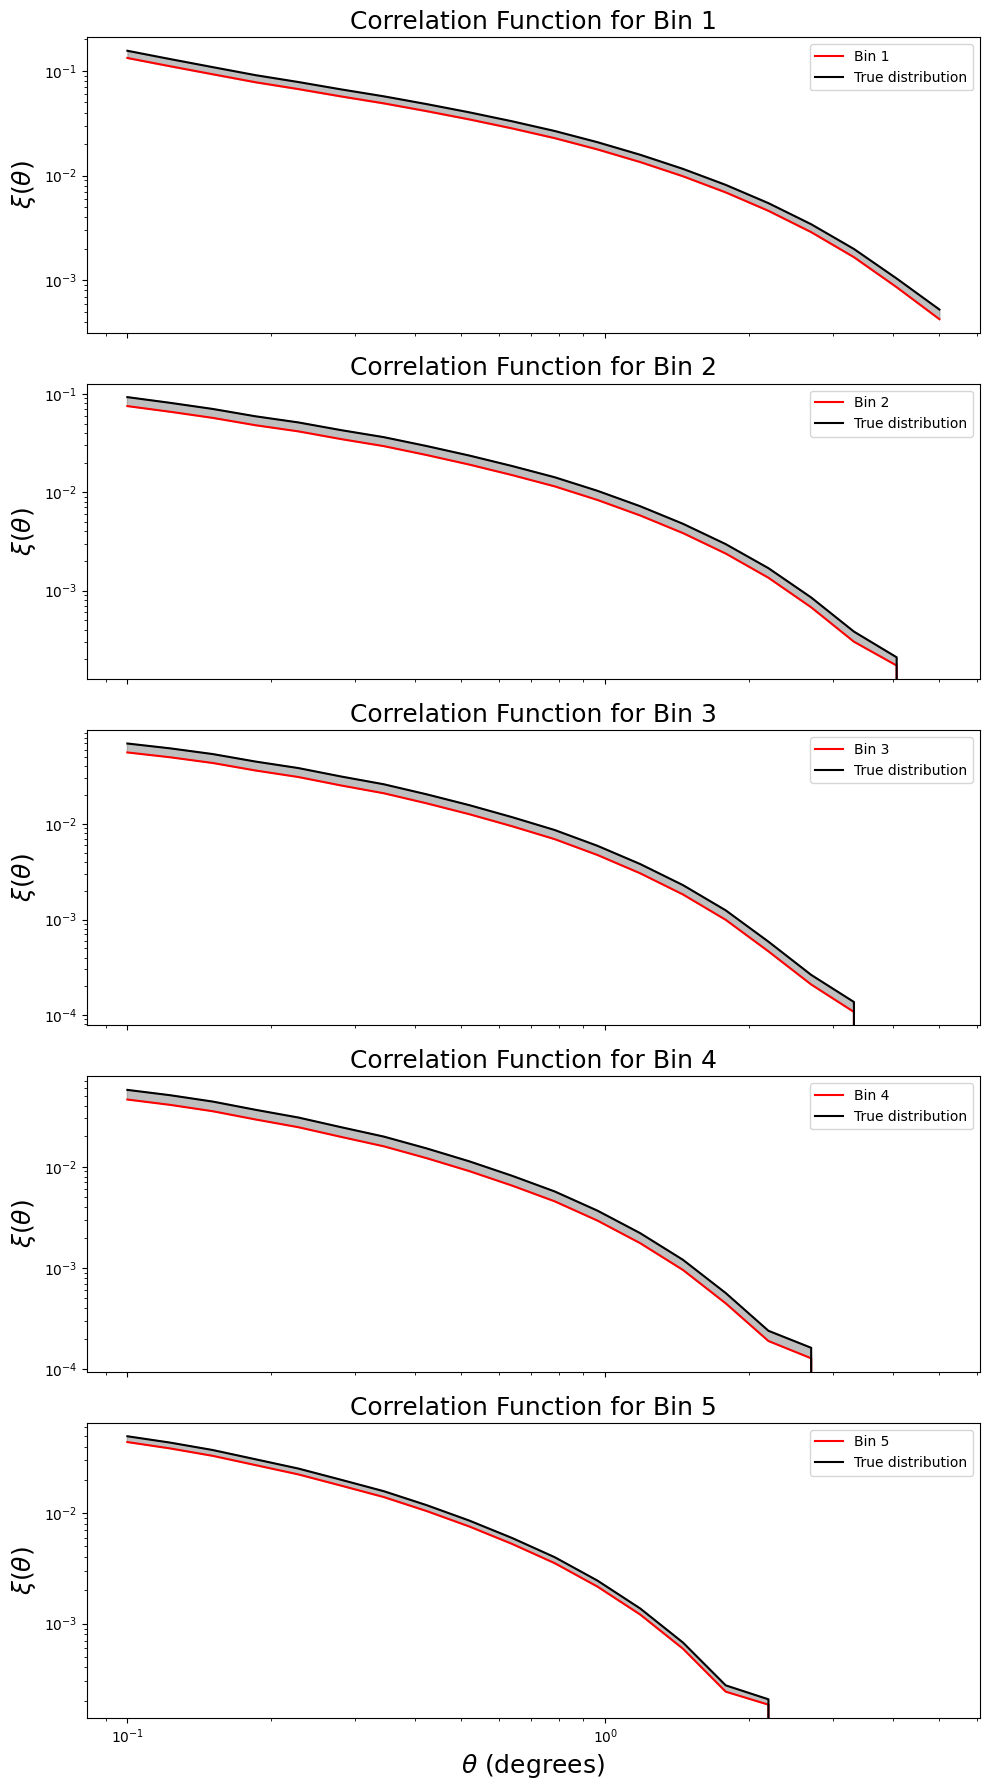

In [ ]:
# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)  # Theta is in degrees

# Calculate correlation functions
xi = []
true_xi = []
for cl, true_cl in zip(cls, true_cls):
    xi.append(ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog'))
    true_xi.append(ccl.correlation(cosmo, ell=ell, C_ell=true_cl, theta=theta_deg, type='NN', method='FFTLog'))

# Plot the correlation functions
fig, axs = plt.subplots(len(bin_edges) - 1, 1, figsize=(10, 18), sharex=True)
for i in range(len(bin_edges) - 1):
    axs[i].plot(theta_deg, xi[i], label=f'Bin {i+1}', color='red')
    axs[i].plot(theta_deg, true_xi[i], label='True distribution', color='black', linestyle='-')
    axs[i].fill_between(theta_deg, xi[i], true_xi[i], color='gray', alpha=0.5)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].legend()
    axs[i].set_ylabel('$\\xi(\\theta)$', fontsize=18)
    axs[i].set_title(f'Correlation Function for Bin {i+1}', fontsize=18)

plt.xlabel('$\\theta$ (degrees)', fontsize=18)
plt.tight_layout()
plt.show()

#Defining the Binning Class

The Binning class and accompanying code are designed to manage and analyze redshift distributions in the context of cosmological surveys. This class helps in binning galaxies by redshift, accounting for uncertainties in photometric redshift measurements, and computing related statistics.

Compute Equal Number Density Bins: The compute_equal_number_bounds method determines the bin edges that result in equal number densities.

Lens Bins: The lens_bins method computes the redshift distributions for each bin, normalizing them if specified.

Plotting: The redshift distributions for each bin are plotted to visualize the results.

Bin edges: [0.0, 0.5202882919494087, 0.7736943304167303, 1.0496648603902614, 1.440447059125124, 3.0]


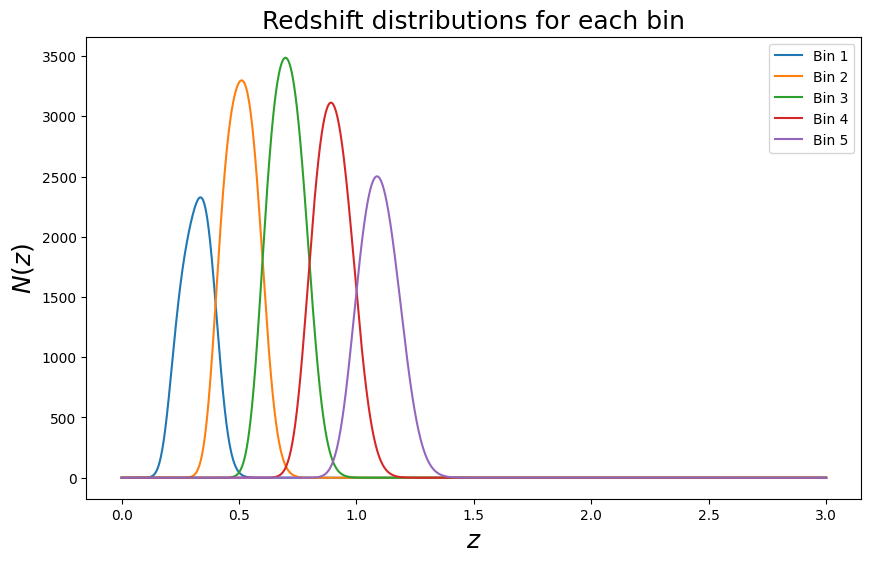

In [ ]:
class Binning:
    def __init__(self, redshift_range, redshift_distribution, forecast_year):
        supported_forecast_years = {"1", "10"}
        if forecast_year in supported_forecast_years:
            self.forecast_year = forecast_year
        else:
            raise ValueError(f"forecast_year must be one of {supported_forecast_years}.")

        self.redshift_range = redshift_range
        self.redshift_distribution = redshift_distribution

        with open("lsst_desc_parameters.yaml", "r") as f:
            self.lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

        self.lens_params = self.lsst_parameters["lens_sample"][self.forecast_year]
        self.source_params = self.lsst_parameters["source_sample"][self.forecast_year]

    def true_redshift_distribution(self, upper_edge, lower_edge, variance, bias):
        scatter = variance * (1 + self.redshift_range)
        # Ensure scatter is not zero
        scatter = np.where(scatter == 0, 1e-10, scatter)
        lower_limit = (upper_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        upper_limit = (lower_edge - self.redshift_range + bias) / np.sqrt(2) / scatter
        true_redshift_distribution = 0.5 * np.array(self.redshift_distribution) * (erf(upper_limit) - erf(lower_limit))
        return true_redshift_distribution

    def compute_equal_number_bounds(self, redshift_range, redshift_distribution, n_bins):
        cumulative_distribution = integrate.cumulative_trapezoid(redshift_distribution, redshift_range, initial=0)
        total_galaxies = cumulative_distribution[-1]
        bin_edges = []
        for i in range(1, n_bins):
            fraction = i / n_bins * total_galaxies
            bin_edge = np.interp(fraction, cumulative_distribution, redshift_range)
            bin_edges.append(bin_edge)
        return [redshift_range[0]] + bin_edges + [redshift_range[-1]]

    def lens_bins(self, normalised=True, save_file=True, file_format='npy'):
        bins = np.arange(self.lens_params["bin_start"],
                         self.lens_params["bin_stop"] + self.lens_params["bin_spacing"],
                         self.lens_params["bin_spacing"])

        lens_z_bias_list = np.repeat(self.lens_params["z_bias"], self.lens_params["n_tomo_bins"])
        lens_z_variance_list = np.repeat(self.lens_params["sigma_z"], self.lens_params["n_tomo_bins"])

        lens_redshift_distribution_dict = {}
        for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
            z_bias = lens_z_bias_list[index]
            z_variance = lens_z_variance_list[index]
            lens_redshift_distribution_dict[index] = self.true_redshift_distribution(x1, x2, z_variance, z_bias)

        if normalised:
            norm_factor = []
            for i, key in enumerate(list(sorted(lens_redshift_distribution_dict.keys()))):

                norm_factor

        combined_data = {'redshift_range': self.redshift_range, 'bins': lens_redshift_distribution_dict}

        if save_file:
            self.save_to_file(combined_data, "lens", file_format)

        return lens_redshift_distribution_dict

    def get_bin_centers(self, decimal_places=2, save_file=True):
        bin_centers = {"sources": [], "lenses": []}
        lens_bins = self.lens_bins(normalised=True, save_file=False)
        for index in range(self.lens_params["n_tomo_bins"]):
            bin_center = self.find_bin_center(lens_bins[index], self.redshift_range, decimal_places)
            bin_centers["lenses"].append(bin_center)
        if save_file:
            np.save(f'./srd_bin_centers_y_{self.forecast_year}.npy', bin_centers)
        return bin_centers

    def find_bin_center(self, bin_distribution, redshift_range, decimal_places=2):
        max_index = np.argmax(bin_distribution)
        return round(redshift_range[max_index], decimal_places)

    def save_to_file(self, data, name, file_format="npy"):
        if file_format == "npy":
            np.save(f"./srd_{name}_bins_year_{self.forecast_year}.npy", data)
        elif file_format == "csv":
            dndz_df = pandas.DataFrame(data)
            dndz_df.to_csv(f"./srd_{name}_bins_year_{self.forecast_year}.csv", index=False)

# Instantiate and use the Binning class
forecast_year = "1"  # For year 1
binning = Binning(z, dNdz, forecast_year)

# Compute equal number density bins
n_bins = 5  # Number of bins for year 1
bin_edges = binning.compute_equal_number_bounds(z, dNdz, n_bins)
print("Bin edges:", bin_edges)

# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)
#print("Lens bins:", lens_bins)

# Plot the redshift distributions for each bin
plt.figure(figsize=(10, 6))
for i in range(n_bins):
    plt.plot(z, lens_bins[i], label=f'Bin {i+1}')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('Redshift distributions for each bin', fontsize=18)
plt.legend()
plt.show()


# Angular Power Spectra Calculation and Plotting
This code computes and plots the angular power spectra C_ℓ for galaxy number counts across multiple redshift bins.

#Axes:

X-axis (ℓ): Represents the angular multipole, which corresponds to different angular scales on the sky. Smaller ℓ values correspond to larger angular scales, and larger ℓ values correspond to smaller angular scales.

Y-axis (C_ℓ): Represents the angular power spectrum, indicating the amount of clustering at each angular scale.
Power Spectra for Each Bin:

Each line corresponds to a different redshift bin, as indicated by the legend (Bin 1, Bin 2, etc.).

The angular power spectrum C_ℓ generally decreases with increasing ℓ, indicating that clustering is stronger on larger scales (smaller ℓ) and weaker on smaller scales (larger ℓ).

#Log-Log Scale:

The log-log scale helps to clearly display the power-law behavior of the angular power spectra over a wide range of scales.

On a log-log scale, straight lines indicate a simple power-law relationship, which is often observed in the power spectra of galaxy clustering.
Scientific Insights
Galaxy Clustering:

The plot provides insights into how galaxies cluster at different angular scales and redshifts. Stronger clustering at large scales (small ℓ) indicates the presence of large-scale structures, such as galaxy clusters and superclusters.

Weaker clustering at small scales (large ℓ) reflects the more uniform distribution of galaxies at smaller separations.

#Redshift Evolution:

By comparing the power spectra across different bins, one can study how galaxy clustering evolves with redshift. Closer bins (lower redshift) might show stronger clustering compared to more distant bins (higher redshift), reflecting the growth of structure over cosmic time.
Cosmological Parameters:

The shape and amplitude of the angular power spectra can provide constraints on cosmological parameters, such as the matter density (Ω_m) and the amplitude of density fluctuations (σ_8).


In [ ]:
# Compute the redshift distributions for each bin
lens_bins = binning.lens_bins(normalised=True, save_file=False)

# Create NumberCountsTracer objects for each bin
tracers = []
for i in range(n_bins):
    z_bin = z[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    dNdz_bin = dNdz[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    bias_bin = b[(z >= bin_edges[i]) & (z < bin_edges[i+1])]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z_bin, dNdz_bin), bias=(z_bin, bias_bin))
    tracers.append(tracer)

# Specify angular multipoles
ell = np.arange(2, 2000)

# Calculate angular power spectra
cls = []
for tracer in tracers:
    cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

# Plot the angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Angular Power Spectra for Each Bin', fontsize=18)
plt.show()


AttributeError: 'RedshiftBinning' object has no attribute 'lens_bins'

#Galaxy-Galaxy Clustering Correlation Functions

# Interpretation of the Plot

#Axes:

X-axis (𝜃): Represents the angular separation between galaxy pairs in degrees, plotted on a logarithmic scale. This allows us to examine the clustering behavior over a wide range of scales.

Y-axis (ξ_clu(θ)): Represents the correlation function, also on a logarithmic scale. Higher values indicate stronger clustering at a given angular separation.
Correlation Functions for Each Bin:

Each line corresponds to a different redshift bin, as indicated by the legend (Bin 1, Bin 2, etc.). These bins represent different slices of the galaxy distribution at varying distances from the observer.

The correlation function ξ_clu(θ) generally decreases with increasing 𝜃, indicating that galaxies are more strongly clustered at smaller angular scales.
Differences between bins reflect how clustering varies with redshift. This could be due to differences in galaxy properties or the underlying large-scale structure.

#Log-Log Scale:

The log-log scale is used to clearly show the power-law behavior of the correlation function over a wide range of scales.
On such a scale, straight lines indicate a simple power-law relationship, which is a common feature in the clustering of galaxies.

# Insights:

#Galaxy Clustering:

The plot provides insights into how galaxies cluster on the sky. Stronger clustering at small scales (θ≲1 degree) indicates the presence of galaxy groups and clusters.

Weaker clustering at larger scales (𝜃≳1 degree) reflects the large-scale structure of the universe, where galaxies are more evenly distributed.

#Redshift Evolution:

By comparing the correlation functions across different bins, one can study how galaxy clustering evolves with redshift. For instance, closer bins (lower redshift) might show stronger clustering compared to more distant bins (higher redshift), reflecting the growth of structure over cosmic time.

Cosmological Parameters:

The shape and amplitude of the correlation functions can provide constraints on cosmological parameters, such as the matter density (Ω_𝑚) and the amplitude of density fluctuations (σ_8).

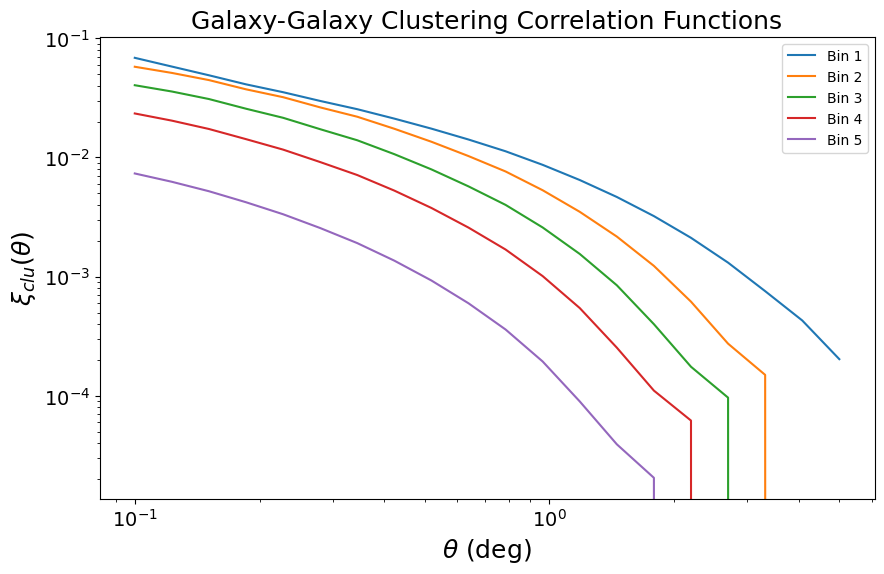

In [ ]:
# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Calculate the correlation function for each bin
correlations = []
for cl in cls:
    xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
    correlations.append(xi_clu)

# Plot the correlations for galaxy-galaxy clustering
plt.figure(figsize=(10, 6))
for i, xi_clu in enumerate(correlations):
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1}')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)', fontsize=18)
plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.show()


# Auto-correlation functions for galaxy clustering as a function of angular separation on the sky (𝜃)

The plots below are calculated for several redshift bins. The correlation functions are computed for both the true redshift distribution and for redshift distributions affected by photo-z uncertainties.

#True Redshift Distribution (Black Line)

This line represents the auto-correlation function calculated using the true redshift distribution of galaxies without any photo-z uncertainty. It serves as the baseline or "true" correlation for comparison.
Photo-z Uncertainties (Shaded Regions):

The shaded regions illustrate how the auto-correlation function changes when photo-z uncertainties are introduced. Each color represents a different level of photo-z uncertainty (𝜎_𝑧).

In this case, 𝜎_𝑧=0.03 is tested, which means that the redshift measurements have a Gaussian uncertainty with a standard deviation of 0.03.

#Angular Scales

The x-axis (𝜃) is on a logarithmic scale, ranging from small angular separations (0.1 degrees) to larger ones (5 degrees). Smaller angles correspond to smaller-scale structures, while larger angles correspond to larger-scale structures.

#Correlation Function (ξ(θ))

The y-axis (𝜉_𝜃) is also on a logarithmic scale. This function measures how galaxy clustering changes with angular separation. Higher values indicate stronger clustering.

#Comparison Across Redshift Bins

Each subplot represents a different redshift bin, which means galaxies are grouped by their distances from Earth. The title of each subplot indicates the mean redshift for that bin.

The black line shows the true correlation function for galaxies in that bin.
Shaded regions show how this correlation function changes when photo-z uncertainties are considered. The bounds of the shaded region represent the range of correlation functions due to these uncertainties.

#Effect of Photo-z Uncertainties

At Small Angular Scales:
Photo-z uncertainties tend to have a more pronounced effect at smaller angular scales. This is because small-scale clustering is more sensitive to precise distance measurements. Any error in redshift translates into a significant error in the inferred angular position.
At Larger Angular Scales:
The effect of photo-z uncertainties diminishes at larger angular scales. This is because the correlation function at these scales is dominated by larger structures, where individual distance errors average out.

#Photo-z Uncertainty

The shaded regions around the black line represent the correlation function when considering a photo-z uncertainty.

In some bins, the effect of this uncertainty is minimal, indicating that the clustering signal is robust against this level of uncertainty.

In other bins, especially at smaller angular scales, the effect is more noticeable, showing a broader range of possible correlation values.

#Color Coding and Interpretation:

The color coding of the shaded regions helps differentiate the impact of different photo-z uncertainties. Here, red shades indicate the presence of photo-z uncertainties.

The boundaries of the shaded regions show the possible range of correlation functions due to the uncertainty, providing a visual representation of the error introduced by photo-z inaccuracies.

#Of note:

Since the true redshift distribution (xi_clu_true) is derived analytically with minimal scatter (sigma_z = 0), it represents an idealized scenario. In contrast, when sigma_z is nonzero, it introduces a realistic scatter that tends to reduce the amplitude of the correlation function due to smearing effects.

 In the plots below, this manifests as the shaded region (fill_between) consistently lying below the solid line of xi_clu_true. This accurately reflects the expected behavior where uncertainties broaden the distribution and thus decrease the measured correlation function relative to its true value.


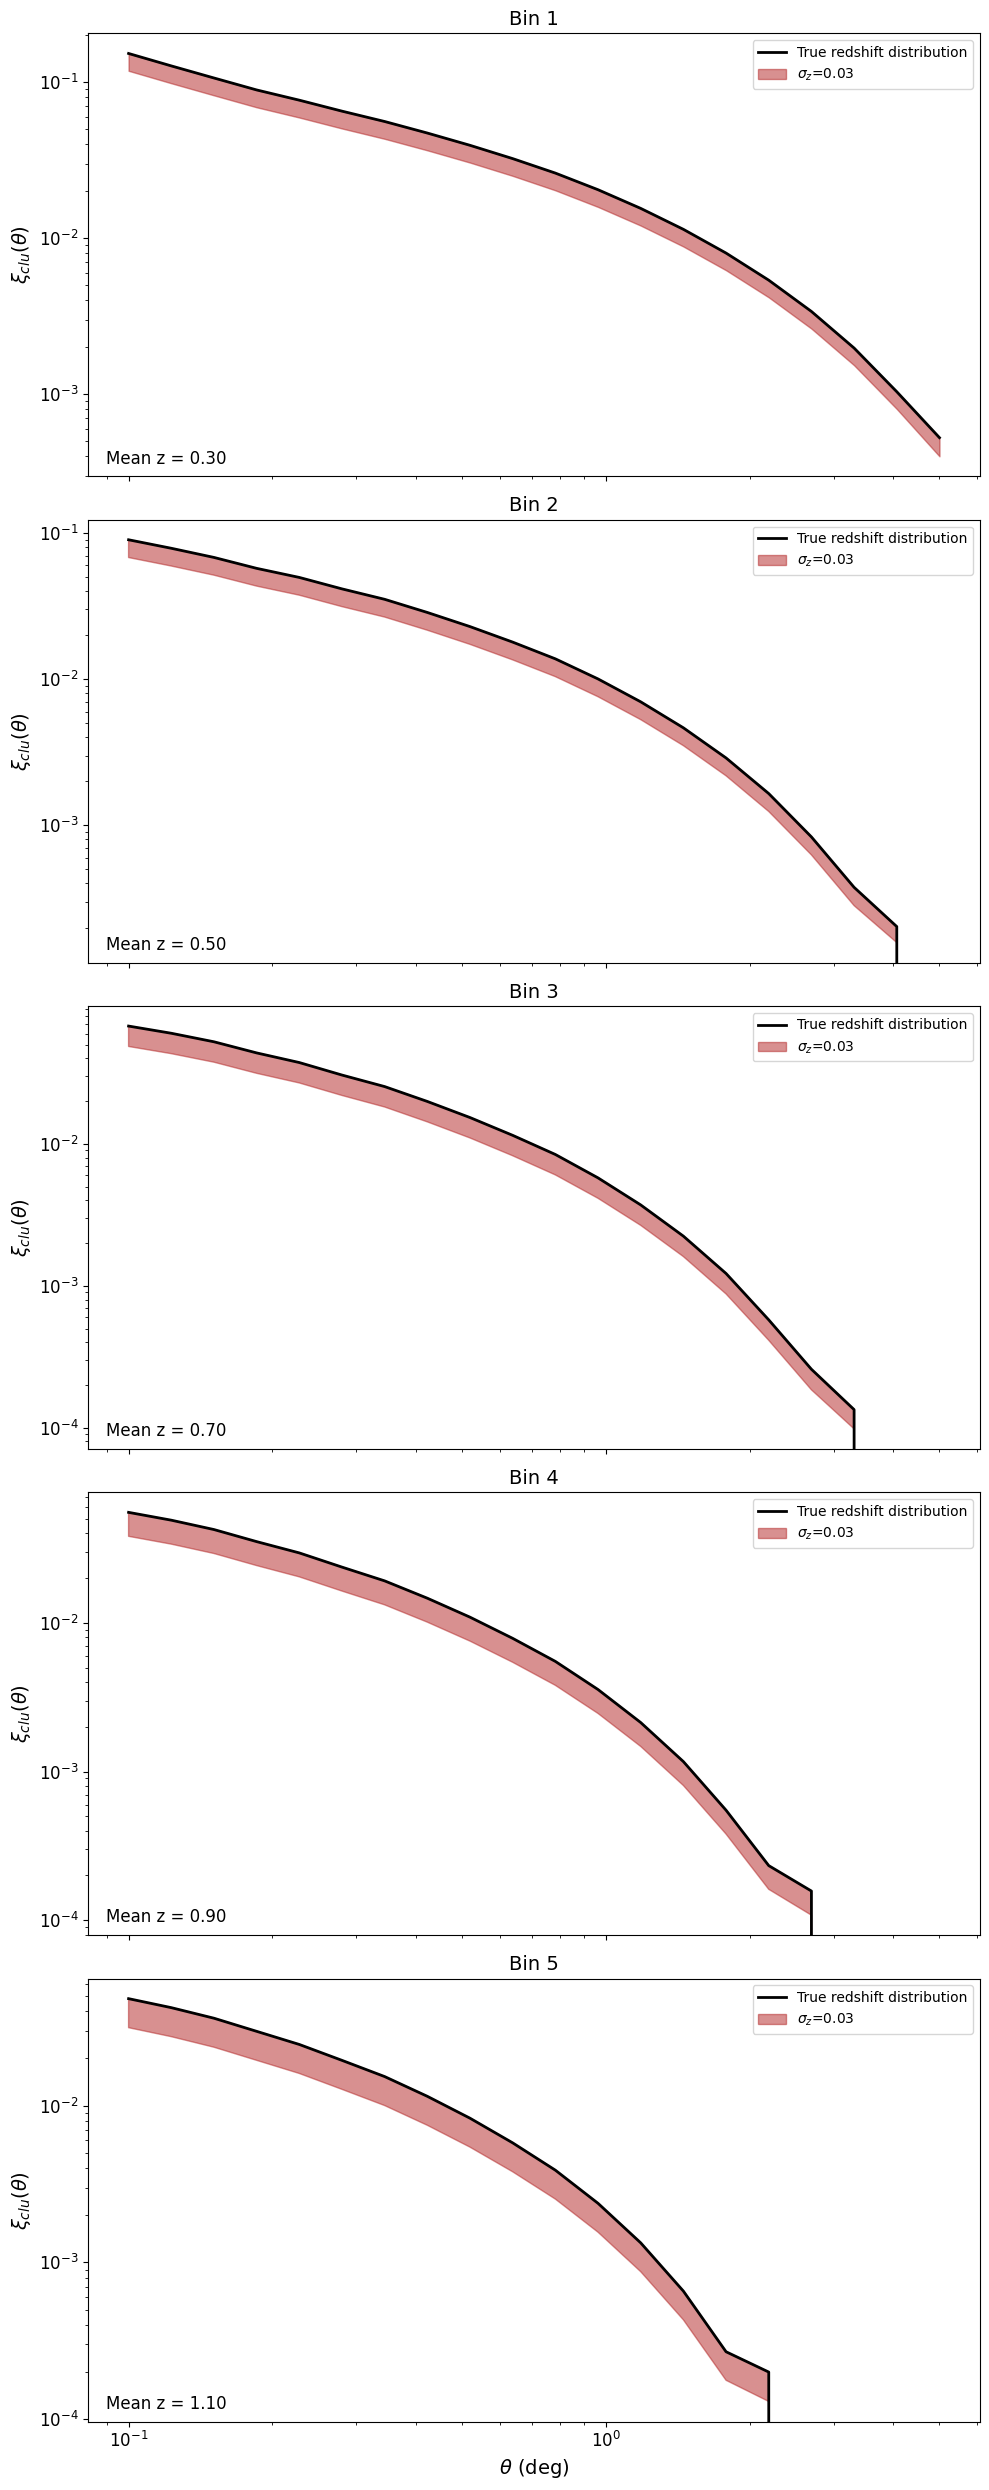

In [ ]:
# Define a range of photo-z uncertainties to test
photoz_uncertainties = [.03]

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Storage for correlation functions for different photo-z uncertainties
correlations_dict = {}

# Define redshift bins
bins = np.arange(binning.lens_params["bin_start"],
                 binning.lens_params["bin_stop"] + binning.lens_params["bin_spacing"],
                 binning.lens_params["bin_spacing"])

# Compute the true redshift distribution (no photo-z uncertainty)
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
    z_bias = binning.lens_params["z_bias"]
    true_lens_redshift_distribution_dict[index] = binning.true_redshift_distribution(x1, x2, 0, z_bias)

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(n_bins):
    dNdz = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, dNdz), bias=(z, b), mag_bias=None)
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((n_bins, len(ell)))
for i in range(n_bins):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((n_bins, len(theta_deg)))
for i in range(n_bins):
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

# Now calculate correlations for different photo-z uncertainties
for sigma_z in photoz_uncertainties:
    lens_redshift_distribution_dict = {}

    for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
        z_bias = binning.lens_params["z_bias"]
        dNdz = binning.true_redshift_distribution(x1, x2, sigma_z, z_bias)

        # Interpolate dNdz to match z's length
 #       z_dNdz = np.linspace(x1, x2, len(dNdz))
 #       dNdz_interpolated = np.interp(z, z_dNdz, dNdz)

        lens_redshift_distribution_dict[index] = dNdz

    # Create the NumberCountsTracer objects for each bin
    tracers = []
    for i in range(n_bins):
        dNdz = lens_redshift_distribution_dict[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, dNdz), bias=(z, b), mag_bias=None)
        tracers.append(tracer)

    # Calculate the angular power spectra for each bin (auto-correlations)
    cls_matrix = np.zeros((n_bins, len(ell)))
    for i in range(n_bins):
        cls_matrix[i] = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell)

    # Calculate the correlation function for each bin
    correlations_matrix = np.zeros((n_bins, len(theta_deg)))
    for i in range(n_bins):
        correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

    # Store the correlations for the current photo-z uncertainty
    correlations_dict[sigma_z] = correlations_matrix

# Plot the auto-correlations for different photo-z uncertainties
fig, axs = plt.subplots(n_bins, 1, figsize=(10, n_bins * 5), sharex=True)
if n_bins == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

colors = ['red', 'darkred', 'firebrick']

for i in range(n_bins):
    mean_z = 0.5 * (bins[i] + bins[i+1])

    # Plot the true redshift distribution correlation
    xi_clu_true = true_correlations_matrix[i]
    axs[i].plot(theta_deg, xi_clu_true, color='black', label='True redshift distribution', linewidth=2)

    # Plot the shaded regions for each photo-z uncertainty
    for sigma_z, correlations_matrix in correlations_dict.items():
      xi_clu = correlations_matrix[i]

      # Calculate the upper and lower bounds
      lower_bound = np.maximum(0, xi_clu_true - (xi_clu_true - xi_clu))
      upper_bound = xi_clu_true + (xi_clu - xi_clu_true)
      # Ensure values are valid for plotting
      valid_indices = (lower_bound > 0) & (upper_bound > 0)
      # Calculate the color index ensuring it stays within the bounds of the colors list
      color_index = min(int(sigma_z * 100 - 1), len(colors) - 1)
      # Plot the fill_between
      axs[i].fill_between(theta_deg, xi_clu_true, xi_clu, color=colors[color_index], alpha=0.5, label=f'$\sigma_z$={sigma_z}')

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=14)
    axs[i].set_title(f'Bin {i+1}', fontsize=14)
    axs[i].text(0.02, 0.02, f'Mean z = {mean_z:.2f}', transform=axs[i].transAxes, fontsize=12, verticalalignment='bottom')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].legend(loc='upper right', fontsize=10)

axs[-1].set_xlabel(r'$\theta$ (deg)', fontsize=14)
plt.tight_layout()
plt.show()


#Redshift Bin Dependence

Below is a visual comparison of how photoz uncertainties vary across different redshift bins, with error bars indicating the spread of uncertainties within each bin. It is to understand how photoz uncertainties vary across different redshift ranges.

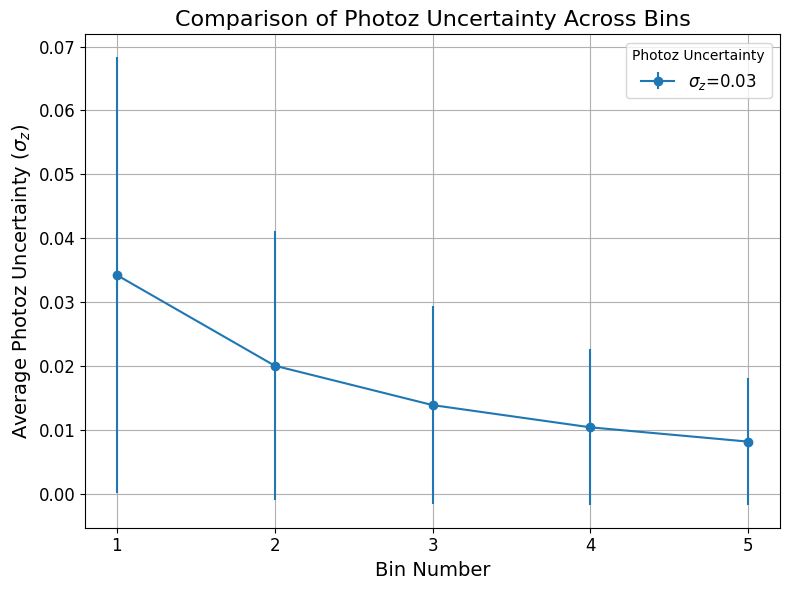

In [ ]:
# Compute mean and error bars (standard deviation or standard error of mean) for each bin
sigma_z_means = []
sigma_z_stdevs = []

for sigma_z, correlations_matrix in correlations_dict.items():
    sigma_z_bin_avg = np.mean(correlations_matrix, axis=1)  # Calculate average sigma_z across theta bins for each redshift bin
    sigma_z_means.append(sigma_z_bin_avg)
    sigma_z_stdev = np.std(correlations_matrix, axis=1)  # Calculate standard deviation across theta bins for each redshift bin
    sigma_z_stdevs.append(sigma_z_stdev)

# Plotting the uncertainties across redshift bins with error bars
plt.figure(figsize=(8, 6))
bin_numbers = np.arange(1, n_bins + 1)  # Bin numbers as x-axis

for i, (sigma_z_vals, sigma_z_err) in enumerate(zip(sigma_z_means, sigma_z_stdevs)):
    plt.errorbar(bin_numbers, sigma_z_vals, yerr=sigma_z_err, fmt='o-', label=f'$\sigma_z$={photoz_uncertainties[i]}')

plt.xlabel('Bin Number', fontsize=14)
plt.ylabel('Average Photoz Uncertainty ($\sigma_z$)', fontsize=14)
plt.title('Comparison of Photoz Uncertainty Across Bins', fontsize=16)
plt.xticks(bin_numbers, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(title='Photoz Uncertainty', fontsize=12)
plt.tight_layout()
plt.show()

# Impact of photoz uncertainties on cosmological parameter estimates

The following code assesses how variations in photoz uncertainties impact the reliability and accuracy of cosmological parameter estimates derived from correlation function analyses.

#Impact of Photo-z Uncertainty:

As the photo-z uncertainty (σ_z) increases, the derived values of Ω_c and h change.

This indicates that photo-z uncertainty has a significant impact on the estimation of cosmological parameters. Larger uncertainties in redshift measurements can bias the inferred cosmological parameters.

Cosmological Parameter Trends:

There is a trend of increasing Ω_c and decreasing h with increasing σ_z.

This could suggest that a broader redshift distribution (due to higher photo-z uncertainty) affects the shape of the angular power spectra, leading to different best-fit cosmological parameters.


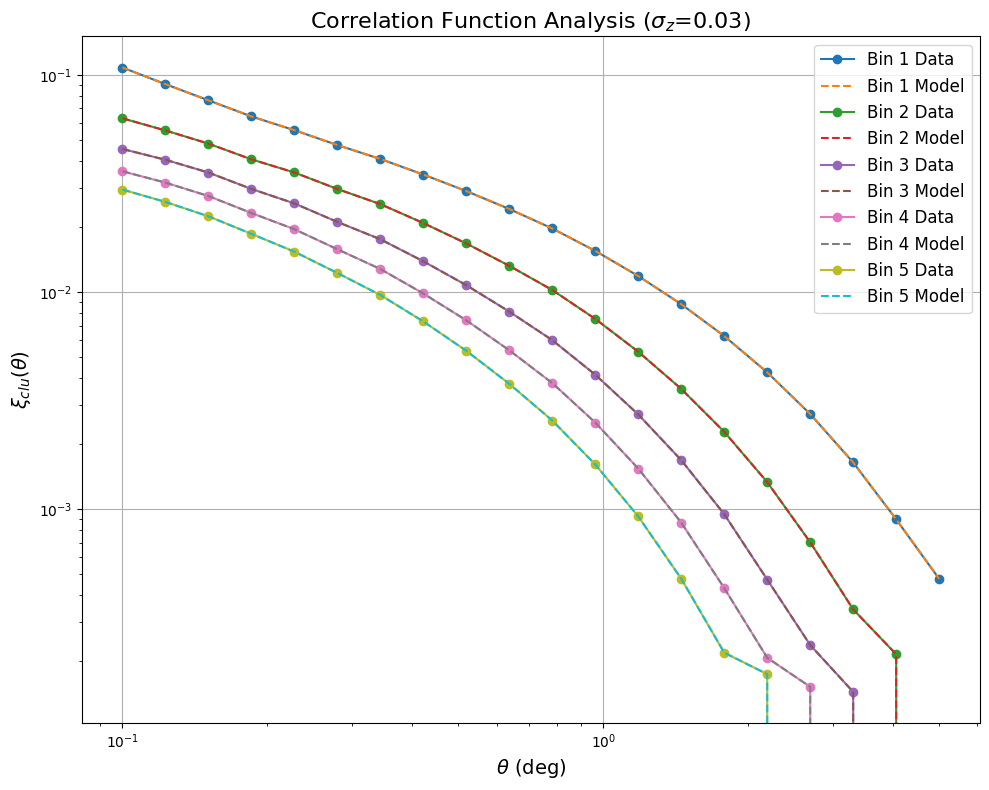

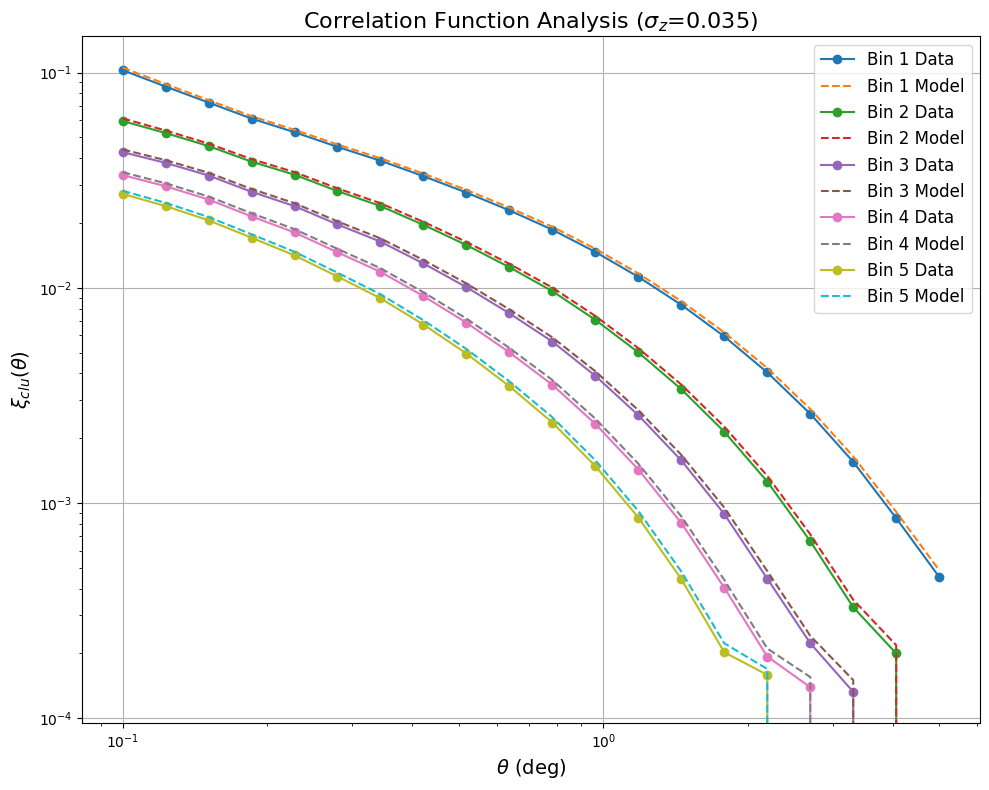

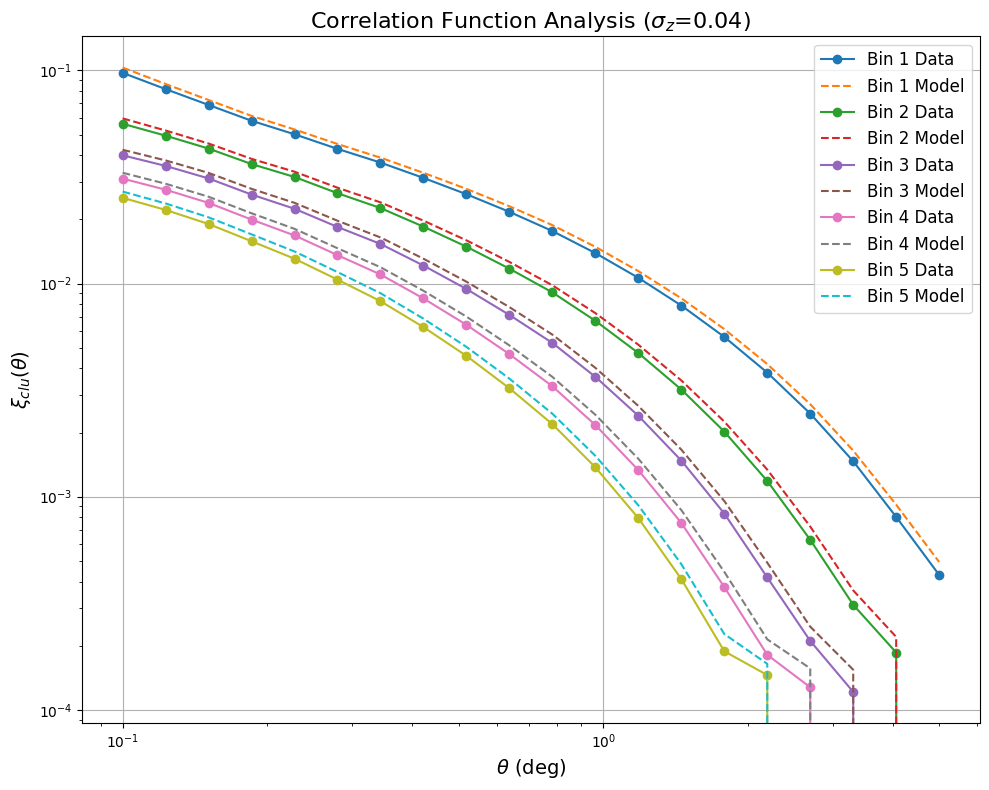

Derived Cosmological Parameters:
sigma_z=0.03: Omega_c = 0.2500, h = 0.7000
sigma_z=0.035: Omega_c = 0.2513, h = 0.6919
sigma_z=0.04: Omega_c = 0.2533, h = 0.6831


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from scipy.optimize import minimize

# Define a range of photo-z uncertainties to test
photoz_uncertainties = [0.03, 0.035, 0.04]  # Adjust as needed

# Define angular scales in degrees
theta_deg = np.logspace(-1, np.log10(5.), 20)

# Define redshift bins
bins = np.arange(binning.lens_params["bin_start"],
                 binning.lens_params["bin_stop"] + binning.lens_params["bin_spacing"],
                 binning.lens_params["bin_spacing"])

# Number of redshift bins
n_bins = len(bins) - 1

# Initialize dictionaries to store data
correlations_dict = {}
true_correlations_dict = {}

# Storage for cosmological parameters
omega_c_values = []
h_values = []

# Initialize cosmology using pyccl Cosmology class
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, sigma8=0.8, h=0.7, n_s=0.96)

# Loop over photo-z uncertainties
for sigma_z in photoz_uncertainties:
    # Compute true redshift distributions and correlation functions without photo-z uncertainty
    true_correlations_matrix = np.zeros((n_bins, len(theta_deg)))
    true_lens_redshift_distribution_dict = {}

    for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
        z_bias = binning.lens_params["z_bias"]
        true_lens_redshift_distribution_dict[index] = binning.true_redshift_distribution(x1, x2, 0, z_bias)

    true_tracers = []
    for i in range(n_bins):
        dNdz = true_lens_redshift_distribution_dict[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, dNdz), bias=(z, b), mag_bias=None)
        true_tracers.append(tracer)

    true_cls_matrix = np.zeros((n_bins, len(ell)))
    for i in range(n_bins):
        true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

    for i in range(n_bins):
        true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

    true_correlations_dict[sigma_z] = true_correlations_matrix

    # Compute redshift distributions and correlation functions with photo-z uncertainty
    lens_redshift_distribution_dict = {}

    for index, (x1, x2) in enumerate(zip(bins[:-1], bins[1:])):
        z_bias = binning.lens_params["z_bias"]
        dNdz = binning.true_redshift_distribution(x1, x2, sigma_z, z_bias)
        lens_redshift_distribution_dict[index] = dNdz

    tracers = []
    for i in range(n_bins):
        dNdz = lens_redshift_distribution_dict[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=True, dndz=(z, dNdz), bias=(z, b), mag_bias=None)
        tracers.append(tracer)

    cls_matrix = np.zeros((n_bins, len(ell)))
    for i in range(n_bins):
        cls_matrix[i] = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell)

    correlations_matrix = np.zeros((n_bins, len(theta_deg)))
    for i in range(n_bins):
        correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

    correlations_dict[sigma_z] = correlations_matrix

    # Fit a model to the correlation function data
    def model(params):
        omega_c, h = params
        cosmo = ccl.Cosmology(Omega_c=omega_c, Omega_b=0.05, sigma8=0.8, h=h, n_s=0.96)
        model_cls = np.zeros((n_bins, len(ell)))
        for i in range(n_bins):
            model_cls[i] = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell)
        model_correlations = np.zeros((n_bins, len(theta_deg)))
        for i in range(n_bins):
            model_correlations[i] = ccl.correlation(cosmo, ell=ell, C_ell=model_cls[i], theta=theta_deg, type='NN', method='FFTLog')
        return model_correlations

    def chi_squared(params):
        model_correlations = model(params)
        chi2 = 0.0
        # Iterate over the keys in the correlations_dict, not photoz_uncertainties
        for sz in correlations_dict:
            chi2 += np.sum((correlations_dict[sz] - model_correlations) ** 2)
        return chi2

    # Initial guess for parameters (Omega_c, h)
    initial_guess = [0.25, 0.7]

    # Perform minimization of chi-squared
    result = minimize(chi_squared, initial_guess, method='Nelder-Mead')
    best_fit_params = result.x

    # Extract best-fit parameters
    omega_c, h = best_fit_params
    omega_c_values.append(omega_c)
    h_values.append(h)

    # Plot correlation function data and best-fit model
    plt.figure(figsize=(10, 8))
    for i in range(n_bins):
        plt.plot(theta_deg, correlations_dict[sigma_z][i], label=f'Bin {i+1} Data', marker='o')
        plt.plot(theta_deg, model([omega_c, h])[i], linestyle='--', label=f'Bin {i+1} Model')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$\theta$ (deg)', fontsize=14)
    plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=14)
    plt.title(f'Correlation Function Analysis ($\sigma_z$={sigma_z})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print the derived cosmological parameters
print("Derived Cosmological Parameters:")
for sigma_z, omega_c, h in zip(photoz_uncertainties, omega_c_values, h_values):
    print(f"sigma_z={sigma_z}: Omega_c = {omega_c:.4f}, h = {h:.4f}")
